<a href="https://colab.research.google.com/github/falahamro/Predictive-/blob/main/Toxicity_in_Freedom_Convoy__Canada_NLP_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Source: https://github.com/AmarS2001/NLP-Toxic-comment-classification/blob/main/NLP_Deep_Learning.ipynb

# Importing Libraries

In [ ]:
import numpy as np, pandas as pd

!pip install talos

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.5 MB/s 
     |████████████████████████████████| 5.4 MB 21.7 MB/s 
     |████████████████████████████████| 52 kB 946 kB/s 
     |████████████████████████████████| 26.4 MB 1.2 MB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 
  Created wheel for chances: filename=chances-0.1.9-py3-none-any.whl size=41608 sha256=348b0126a498b412179408250c3fa4a96c37b4628fc00ce342f46e7a5c360e64
  Stored in directory: /root/.cache/pip/wheels/f3/2e/7e/316f7da11ccf2195ff05e4a0186a4b5975be9bd0b0004198b6
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=12583cca27d4f0c9d14292f39c8eca2b834398ac9c959226dd25efec7062d499
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built chances sklearn


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

# Importing Data

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
train=pd.read_csv("/content/drive/MyDrive/toxicity_model_citizen_helper/toxic_train.csv")

In [ ]:
train.shape

(159571, 8)

In [ ]:
test=pd.read_csv("/content/drive/MyDrive/toxicity_model_citizen_helper/final_cluster_MFD_LDA.csv")

In [ ]:
test.head()
#test.shape

,Unnamed: 0,author_id,author_followers_x,author_followee_x,listed_count_x,author_tweets_x,text,created_at,retweets_x,replies_x,...,avg_word_length,avg_sentence_length,clean_post,total_words,authority/subversion,care/harm,fairness/cheating,liberty/oppression,loyalty/betrayal,sanctity/degradation
0,0,1486037056040030210,15,127,0,1097,people think pointless believe punitivemandate...,2022-04-18 15:58:13+00:00,2,0,...,10.714286,14.0,"['people', 'think', 'pointless', 'believe', 'p...",14,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1512323000430903298,819,1045,0,1544,working guys hardworking parents mostly moms t...,2022-04-18 15:17:03+00:00,0,0,...,8.235294,17.0,"['working', 'guys', 'hardworking', 'parents', ...",17,0.0,0.0,0.0,0.0,0.0,0.0
2,2,917413322,391,1158,4,27255,ztpetrizzo truckerconvoy still,2022-04-18 15:04:20+00:00,0,0,...,10.000000,3.0,"['ztpetrizzo', 'truckerconvoy', 'still']",3,0.0,0.0,0.0,0.0,0.0,0.0
3,3,50800784,128,215,4,3740,rex murphy always spot analysis cdnpoli onpoli...,2022-04-18 13:52:15+00:00,3,1,...,10.846154,13.0,"['rex', 'murphy', 'always', 'spot', 'analysis'...",13,0.0,0.0,0.0,0.0,0.0,0.0
4,4,58819354,1080,3212,115,128210,reposted canthink twitter sammysleuth truckerc...,2022-04-17 23:43:53+00:00,0,0,...,11.235294,17.0,"['reposted', 'canthink', 'twitter', 'sammysleu...",17,0.0,0.0,0.0,0.0,0.0,0.0


# Data Exploration

Checking for missing values

In [ ]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [ ]:
test.isnull().any()


Unnamed: 0              False
author_id               False
author_followers_x      False
author_followee_x       False
listed_count_x          False
author_tweets_x         False
text                     True
created_at              False
retweets_x              False
replies_x               False
likes_x                 False
quote_count_x           False
Unnamed: 0.1            False
Analysis                False
Final_Sentiment         False
Negative                False
Neutral                 False
Polarity                False
Positive                False
REPEAT_TIME             False
Reach                   False
Subjectivity            False
author_followee_y       False
author_followers_y      False
author_tweets_y         False
likes_y                 False
listed_count_y          False
quote_count_y           False
replies_y               False
retweets_y              False
sociability             False
total_len               False
KMeans                  False
word_count

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [ ]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck ':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [ ]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):
  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      c = 0
      for pat in patterns:
        if text == pat:
          text=str(text).replace(pat, target)
          c = 1
          break
      if c == 1:
        break
  #print(text)
  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 
  #print(text)
  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  #print(text)
  return text 

Cleaning Training Data

In [ ]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [ ]:
test.rename(columns = {'text':'comment_text'}, inplace=True)

In [ ]:
test = test.dropna()

In [ ]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1048]

'sfgate disgrace cfornia trucker convoy disbands angry supporters vent facebook truckerconvoy tkr googlenews'

## Lemmatization

In [ ]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [ ]:
comments_test

0        people think pointless believe punitivemandate...
1        working guys hardworking parents mostly moms t...
2                           ztpetrizzo truckerconvoy still
3        rex murphy always spot analysis cdnpoli onpoli...
4        reposted canthink twitter sammysleuth truckerc...
                               ...                        
43443    sure sure truckerconvoy truckersforfreedom qww...
43444    justintrudeau yasirnaqvi everyone sold soon bl...
43445    goal shut country dissolve parliament truckers...
43446    trudope going needs quebec vote going get busy...
43447    currently canada canadahasfallen truckersforfr...
Name: comment_text, Length: 43447, dtype: object

In [ ]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()

In [ ]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=159571): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
lemmatized_train_data[152458]

'i agree with you about graemel s intention he be a revert nazi and wikipedia ha a way of protect against this report him to the wp rr three revert rule notice board post by report the revert nazi graemel ha show himself herself to be a revert nazi this be unacceptable on a site that be make by it s user and not it s admins if you feel you have be unjustly revert more than time over a hour period please report him her to the three revert noticeboard wp rr it be time to take back what be ours'

Lemmatizing Test Data

In [ ]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=len(comments_test)): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/43447 [00:00<?, ?it/s]

In [ ]:
lemmatized_test_data[10]

'thejagmeetsingh deeply concern jagmeete sanctimonious clown saw handle truckerconvoy'

## Stopwords Removal

In [ ]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [ ]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [ ]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [ ]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [ ]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [ ]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [ ]:
def string_combine_a(stopword):
  final_a=""
  for item in range(39893):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(39893,79785):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(79785,119678):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(119678,159571):
    final_d=final_d+" "+stopword[item]
  return final_d

In [ ]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [ ]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [ ]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [ ]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [ ]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [ ]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [ ]:
print(common_potential_stopwords)

['know', 'point', 'write', 'information', 'link', 'find', 'read', 'new', 'talk', 'source', 'like', 'people', 'way', 'wikipedia', 'use', 'change', 'need', 'page', 'don', 'doe', 'edit', 'fact', 'comment', 'add', 'want', 'deletion', 'try', 'work', 'delete', 'thing', 'mean', 'look', 'time', 'section', 'thank', 'block', 'list', 'image', 'article', 'think', 'good', 'remove', 'reference', 'question', 'editor', 'user', 'help']


Retaining certain words and removing others from the above list

In [ ]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [ ]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [ ]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [ ]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=159571): 
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/159571 [00:00<?, ?it/s]

In [ ]:
processed_train_data[152458]

'agree graemel intention revert nazi protect report revert rule notice board post report revert nazi graemel revert nazi unacceptable site admins feel unjustly revert hour period report revert noticeboard'

Removing Stopwords from Test Data

In [ ]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=153164): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/153164 [00:00<?, ?it/s]

# Model Building

In [ ]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [ ]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  149124


Padding

In [ ]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [ ]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   575    11 32239   239   192    11 32239   239    89    11   578
    11   116   364   575     1  1080   116   336  5361   116   119    11
   385   269   364   575    11     1  1342   116    11   385     2    32
   116   575   192   116   172    46    84   578   116   575    11     2
   486   105    10  1084   401  1071    11  2404   487    36   116    11
   192   405   364     9   255   192   242   149   109    18    19    29
   172    77    19     3   257  4544     4    11 32239   239   192    11
 32239   239    89   171   385   310    68   578    34    44    77   421
  1550    34   171     8   578  1267    77  1636   134    10   134  4675
   134    93    44   564  1254    17    77  1339   118   134  1576    77
  1132     4   505    77   432    31   171    68    34   168  2210   447
    31   313  1529    70   172   236   149   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   578
     4    31   171   192    

In [ ]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [ ]:
X_t = X_t[indices]
labels = y[indices]

### Splitting data into Training and Validation Set

In [ ]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
num_validation_samples
y_train.shape

(127657, 6)

In [ ]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12217  1274  6744   379  6273  1095]
validation:  [3077  321 1705   99 1604  310]


### Importing Fast Text

In [ ]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
 
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1YXPvvVWvdVcY-ramuUR6Q5aOEFnZhPan/view'
id = link.split("/")[-2]
 
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('wiki-news-300d-1M.vec')

In [ ]:
embeddings_index_fasttext = {}
f = open("/content/wiki-news-300d-1M.vec", encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [ ]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


In [ ]:
embedding_matrix_fasttext.shape

(149125, 300)

### Creating Model

#### Talos Grid Search  for LSTM Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 54s 12ms/step - loss: 0.0640 - accuracy: 0.9432 - val_loss: 0.0502 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0508 - accuracy: 0.9893 - val_loss: 0.0482 - val_accuracy: 0.9938


  6%|▌         | 1/18 [01:41<28:51, 101.83s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0714 - accuracy: 0.9028 - val_loss: 0.0518 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0532 - accuracy: 0.9861 - val_loss: 0.0487 - val_accuracy: 0.9938


 11%|█         | 2/18 [03:17<26:08, 98.01s/it] 

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0666 - accuracy: 0.9000 - val_loss: 0.0518 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0508 - accuracy: 0.9713 - val_loss: 0.0477 - val_accuracy: 0.9932


 17%|█▋        | 3/18 [04:52<24:12, 96.83s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0663 - accuracy: 0.9404 - val_loss: 0.0515 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0514 - accuracy: 0.9857 - val_loss: 0.0475 - val_accuracy: 0.9938


 22%|██▏       | 4/18 [06:28<22:29, 96.38s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0626 - accuracy: 0.9517 - val_loss: 0.0491 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0495 - accuracy: 0.9922 - val_loss: 0.0465 - val_accuracy: 0.9935


 28%|██▊       | 5/18 [08:03<20:48, 96.06s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0634 - accuracy: 0.9260 - val_loss: 0.0492 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0507 - accuracy: 0.9871 - val_loss: 0.0480 - val_accuracy: 0.9935


 33%|███▎      | 6/18 [09:39<19:10, 95.90s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0648 - accuracy: 0.9263 - val_loss: 0.0503 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 51s 13ms/step - loss: 0.0502 - accuracy: 0.9866 - val_loss: 0.0483 - val_accuracy: 0.9938


 39%|███▉      | 7/18 [11:24<18:07, 98.85s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0700 - accuracy: 0.9277 - val_loss: 0.0511 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0525 - accuracy: 0.9901 - val_loss: 0.0486 - val_accuracy: 0.9938


 44%|████▍     | 8/18 [13:09<16:48, 100.83s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0619 - accuracy: 0.9456 - val_loss: 0.0532 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 51s 13ms/step - loss: 0.0500 - accuracy: 0.9813 - val_loss: 0.0492 - val_accuracy: 0.9938


 50%|█████     | 9/18 [14:54<15:19, 102.18s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0670 - accuracy: 0.9321 - val_loss: 0.0514 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0517 - accuracy: 0.9915 - val_loss: 0.0473 - val_accuracy: 0.9938


 56%|█████▌    | 10/18 [16:39<13:44, 103.04s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0622 - accuracy: 0.9264 - val_loss: 0.0486 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0489 - accuracy: 0.9747 - val_loss: 0.0462 - val_accuracy: 0.9938


 61%|██████    | 11/18 [18:24<12:05, 103.62s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0651 - accuracy: 0.9148 - val_loss: 0.0508 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 50s 13ms/step - loss: 0.0515 - accuracy: 0.9872 - val_loss: 0.0476 - val_accuracy: 0.9937


 67%|██████▋   | 12/18 [20:09<10:23, 103.92s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0651 - accuracy: 0.9165 - val_loss: 0.0498 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0494 - accuracy: 0.9888 - val_loss: 0.0473 - val_accuracy: 0.9934


 72%|███████▏  | 13/18 [21:49<08:34, 102.83s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0644 - accuracy: 0.9353 - val_loss: 0.0490 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0506 - accuracy: 0.9901 - val_loss: 0.0476 - val_accuracy: 0.9938


 78%|███████▊  | 14/18 [23:29<06:48, 102.05s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0618 - accuracy: 0.9320 - val_loss: 0.0498 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0499 - accuracy: 0.9824 - val_loss: 0.0484 - val_accuracy: 0.9932


 83%|████████▎ | 15/18 [25:09<05:04, 101.38s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0644 - accuracy: 0.9282 - val_loss: 0.0505 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0512 - accuracy: 0.9767 - val_loss: 0.0479 - val_accuracy: 0.9938


 89%|████████▉ | 16/18 [26:49<03:21, 100.96s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0594 - accuracy: 0.9670 - val_loss: 0.0486 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0489 - accuracy: 0.9922 - val_loss: 0.0465 - val_accuracy: 0.9937


 94%|█████████▍| 17/18 [28:29<01:40, 100.79s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 51s 12ms/step - loss: 0.0627 - accuracy: 0.9318 - val_loss: 0.0495 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 48s 12ms/step - loss: 0.0505 - accuracy: 0.9810 - val_loss: 0.0470 - val_accuracy: 0.9938


100%|██████████| 18/18 [30:09<00:00, 100.52s/it]


In [ ]:
scan_results.saved_weights

[[array([[ 0.93228674,  0.49251953,  0.23847152, ...,  0.94839555,
           0.7270696 ,  0.96453345],
         [-0.1303    ,  0.0233    ,  0.1684    , ...,  0.032     ,
          -0.0504    , -0.0821    ],
         [ 0.1045    ,  0.0743    , -0.0524    , ...,  0.1756    ,
           0.0372    ,  0.0854    ],
         ...,
         [ 0.1157901 ,  0.40997586,  0.14018393, ...,  0.7957915 ,
           0.9904861 ,  0.63248867],
         [-0.0078    , -0.1322    , -0.0937    , ..., -0.1202    ,
           0.1493    , -0.0449    ],
         [-0.0418    , -0.1274    , -0.0651    , ..., -0.0352    ,
          -0.1279    , -0.0047    ]], dtype=float32),
  array([[-0.02101025, -0.0539122 ,  0.12445096, ..., -0.18347958,
           0.01623644,  0.07069056],
         [-0.13337298,  0.07647954, -0.07750338, ...,  0.10714197,
          -0.13299501,  0.330693  ],
         [ 0.07242678,  0.06117693,  0.02019893, ...,  0.02025617,
          -0.05817019,  0.28942525],
         ...,
         [-0.122763

In [ ]:
scan_results.saved_weights

[[array([[ 0.93228674,  0.49251953,  0.23847152, ...,  0.94839555,
           0.7270696 ,  0.96453345],
         [-0.1303    ,  0.0233    ,  0.1684    , ...,  0.032     ,
          -0.0504    , -0.0821    ],
         [ 0.1045    ,  0.0743    , -0.0524    , ...,  0.1756    ,
           0.0372    ,  0.0854    ],
         ...,
         [ 0.1157901 ,  0.40997586,  0.14018393, ...,  0.7957915 ,
           0.9904861 ,  0.63248867],
         [-0.0078    , -0.1322    , -0.0937    , ..., -0.1202    ,
           0.1493    , -0.0449    ],
         [-0.0418    , -0.1274    , -0.0651    , ..., -0.0352    ,
          -0.1279    , -0.0047    ]], dtype=float32),
  array([[-0.02101025, -0.0539122 ,  0.12445096, ..., -0.18347958,
           0.01623644,  0.07069056],
         [-0.13337298,  0.07647954, -0.07750338, ...,  0.10714197,
          -0.13299501,  0.330693  ],
         [ 0.07242678,  0.06117693,  0.02019893, ...,  0.02025617,
          -0.05817019,  0.28942525],
         ...,
         [-0.122763

In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[2, 101.27545046806335, 30, 'relu', 2, 32, '09/07/22-160200',
        'sigmoid', '09/07/22-160342', 'adam', 40, 0.1, 0],
       [2, 104.46329188346863, 30, 'relu', 2, 32, '09/07/22-161325',
        'sigmoid', '09/07/22-161509', 'adam', 50, 0.2, 1],
       [2, 99.36625075340271, 40, 'relu', 2, 32, '09/07/22-162710',
        'sigmoid', '09/07/22-162849', 'adam', 60, 0.2, 2],
       [2, 99.62883448600769, 30, 'relu', 2, 32, '09/07/22-162350',
        'sigmoid', '09/07/22-162529', 'adam', 60, 0.2, 3],
       [2, 104.32865047454834, 50, 'relu', 2, 32, '09/07/22-161840',
        'sigmoid', '09/07/22-162024', 'adam', 50, 0.1, 4],
       [2, 94.7836902141571, 30, 'relu', 2, 32, '09/07/22-160342',
        'sigmoid', '09/07/22-160517', 'adam', 40, 0.2, 5],
       [2, 104.54306983947754, 40, 'relu', 2, 32, '09/07/22-161510',
        'sigmoid', '09/07/22-161654', 'adam', 50, 0.1, 6],
       [2, 104.32059812545776, 40, 'relu', 2, 32, '09/07/22-161655',
        'sigmoid', '09/07/22-161839', '

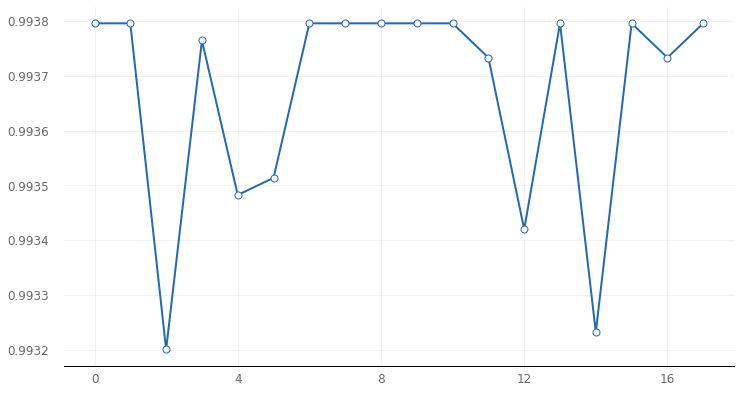

In [ ]:
analyze_object.plot_line('val_accuracy')

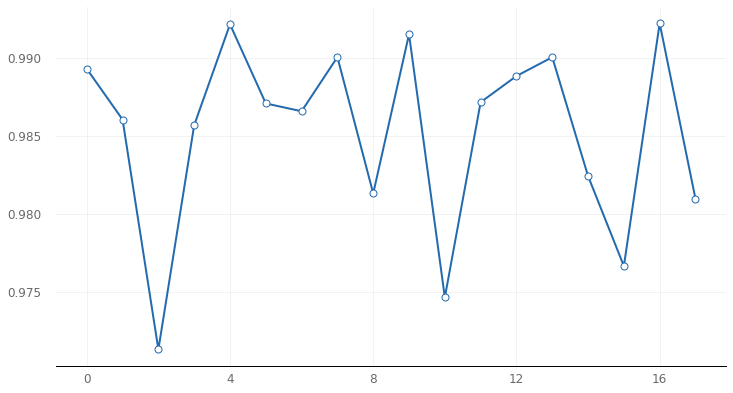

In [ ]:
analyze_object.plot_line('accuracy')

#### Talos Grid Search  for LSTM-CNN Model

In [ ]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)

  x = Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], padding='same', activation='relu', kernel_initializer='he_uniform')(x)

  x = MaxPooling1D(params['pool_size'])(x)
  
  x = GlobalMaxPool1D()(x)
  
  x = BatchNormalization()(x)
  
  x = Dense(params['output_1_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)

  x = Dense(params['output_2_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [ ]:
p={
    'output_count_lstm': [50,60],
    'output_1_count_dense': [40,50],
    'output_2_count_dense': [30,40],
    'filters' : [64],
    'kernel_size' : [3],
    'batch_size': [32],
    'pool_size': [3],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [ ]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|          | 0/16 [00:00<?, ?it/s]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 66s 14ms/step - loss: 0.0655 - accuracy: 0.8731 - val_loss: 0.0538 - val_accuracy: 0.9931
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0530 - accuracy: 0.9743 - val_loss: 0.0492 - val_accuracy: 0.9938


  6%|▋         | 1/16 [02:02<30:35, 122.39s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0726 - accuracy: 0.8758 - val_loss: 0.0542 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0545 - accuracy: 0.9768 - val_loss: 0.0495 - val_accuracy: 0.9938


 12%|█▎        | 2/16 [03:56<27:27, 117.71s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0652 - accuracy: 0.9381 - val_loss: 0.0540 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0525 - accuracy: 0.9723 - val_loss: 0.0498 - val_accuracy: 0.9933


 19%|█▉        | 3/16 [05:50<25:07, 115.93s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0699 - accuracy: 0.8815 - val_loss: 0.0545 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0544 - accuracy: 0.9827 - val_loss: 0.0504 - val_accuracy: 0.9936


 25%|██▌       | 4/16 [07:44<23:00, 115.05s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0647 - accuracy: 0.9188 - val_loss: 0.0540 - val_accuracy: 0.9805
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0525 - accuracy: 0.9721 - val_loss: 0.0484 - val_accuracy: 0.9938


 31%|███▏      | 5/16 [09:38<21:00, 114.59s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0727 - accuracy: 0.9042 - val_loss: 0.0546 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0554 - accuracy: 0.9879 - val_loss: 0.0512 - val_accuracy: 0.9938


 38%|███▊      | 6/16 [11:32<19:06, 114.66s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 59s 14ms/step - loss: 0.0649 - accuracy: 0.9108 - val_loss: 0.0529 - val_accuracy: 0.9922
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0525 - accuracy: 0.9747 - val_loss: 0.0485 - val_accuracy: 0.9934


 44%|████▍     | 7/16 [13:28<17:13, 114.86s/it]

{'output_count_lstm': 50, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0710 - accuracy: 0.9118 - val_loss: 0.0549 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0547 - accuracy: 0.9741 - val_loss: 0.0535 - val_accuracy: 0.9936


 50%|█████     | 8/16 [15:22<15:17, 114.67s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0669 - accuracy: 0.9107 - val_loss: 0.0537 - val_accuracy: 0.9918
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0526 - accuracy: 0.9768 - val_loss: 0.0523 - val_accuracy: 0.9937


 56%|█████▋    | 9/16 [17:11<13:11, 113.01s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0699 - accuracy: 0.8960 - val_loss: 0.0586 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0548 - accuracy: 0.9820 - val_loss: 0.0540 - val_accuracy: 0.9937


 62%|██████▎   | 10/16 [19:01<11:12, 112.01s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0657 - accuracy: 0.9001 - val_loss: 0.0540 - val_accuracy: 0.9934
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0528 - accuracy: 0.9823 - val_loss: 0.0500 - val_accuracy: 0.9936


 69%|██████▉   | 11/16 [20:50<09:15, 111.14s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 40, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0695 - accuracy: 0.9145 - val_loss: 0.0545 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0545 - accuracy: 0.9809 - val_loss: 0.0525 - val_accuracy: 0.9937


 75%|███████▌  | 12/16 [22:39<07:22, 110.53s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0674 - accuracy: 0.9002 - val_loss: 0.0585 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0524 - accuracy: 0.9843 - val_loss: 0.0548 - val_accuracy: 0.9935


 81%|████████▏ | 13/16 [24:29<05:30, 110.22s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 30, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0678 - accuracy: 0.8800 - val_loss: 0.0564 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 53s 13ms/step - loss: 0.0547 - accuracy: 0.9759 - val_loss: 0.0501 - val_accuracy: 0.9938


 88%|████████▊ | 14/16 [26:18<03:39, 109.97s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0657 - accuracy: 0.9053 - val_loss: 0.0542 - val_accuracy: 0.9900
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0523 - accuracy: 0.9875 - val_loss: 0.0516 - val_accuracy: 0.9930


 94%|█████████▍| 15/16 [28:08<01:49, 109.76s/it]

{'output_count_lstm': 60, 'output_1_count_dense': 50, 'output_2_count_dense': 40, 'filters': 64, 'kernel_size': 3, 'batch_size': 32, 'pool_size': 3, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 56s 13ms/step - loss: 0.0701 - accuracy: 0.8809 - val_loss: 0.0681 - val_accuracy: 0.9937
Epoch 2/2
3990/3990 [==============================] - 52s 13ms/step - loss: 0.0545 - accuracy: 0.9734 - val_loss: 0.0509 - val_accuracy: 0.9936


100%|██████████| 16/16 [29:57<00:00, 112.34s/it]


In [ ]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

0

In [ ]:
scan_results.data[8:9]

,start,end,duration,round_epochs,loss,accuracy,val_loss,val_accuracy,output_count_lstm,output_1_count_dense,...,filters,kernel_size,batch_size,pool_size,epochs,optimizer,activation,last_activation,dropout,loss
8,09/07/22-164733,09/07/22-164922,108.709167,2,0.05264,0.976789,0.052301,0.99367,60,40,...,64,3,32,3,2,adam,relu,sigmoid,0.1,binary_crossentropy


In [ ]:
analyze_object = talos.Analyze(scan_results)

In [ ]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[30, 2, 121.66267943382263, 'relu', 40, 2, 64, 32,
        '09/07/22-163211', 3, 3, 'sigmoid', '09/07/22-163412', 'adam',
        50, 0.1, 0],
       [30, 2, 113.78554058074951, 'relu', 40, 2, 64, 32,
        '09/07/22-163413', 3, 3, 'sigmoid', '09/07/22-163607', 'adam',
        50, 0.2, 1],
       [30, 2, 113.14088487625122, 'relu', 50, 2, 64, 32,
        '09/07/22-163955', 3, 3, 'sigmoid', '09/07/22-164148', 'adam',
        50, 0.1, 2],
       [30, 2, 114.1457200050354, 'relu', 50, 2, 64, 32,
        '09/07/22-164149', 3, 3, 'sigmoid', '09/07/22-164343', 'adam',
        50, 0.2, 3],
       [30, 2, 108.75070858001709, 'relu', 50, 2, 64, 32,
        '09/07/22-165640', 3, 3, 'sigmoid', '09/07/22-165829', 'adam',
        60, 0.2, 4],
       [30, 2, 109.14710187911987, 'relu', 40, 2, 64, 32,
        '09/07/22-164923', 3, 3, 'sigmoid', '09/07/22-165112', 'adam',
        60, 0.2, 5],
       [40, 2, 108.49136900901794, 'relu', 40, 2, 64, 32,
        '09/07/22-165301', 3, 3, 'sigmoid',

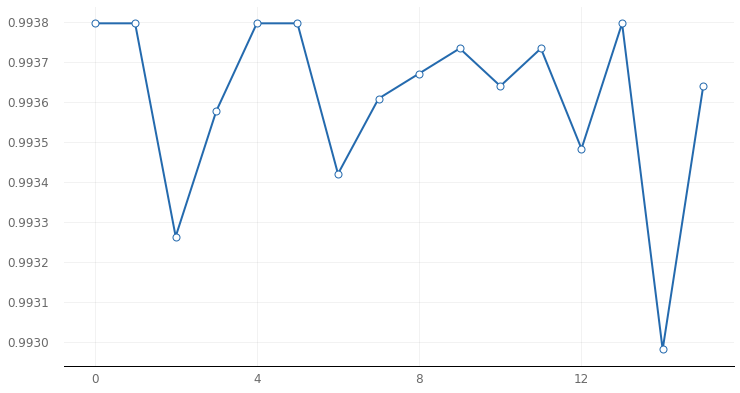

In [ ]:
analyze_object.plot_line('val_accuracy')

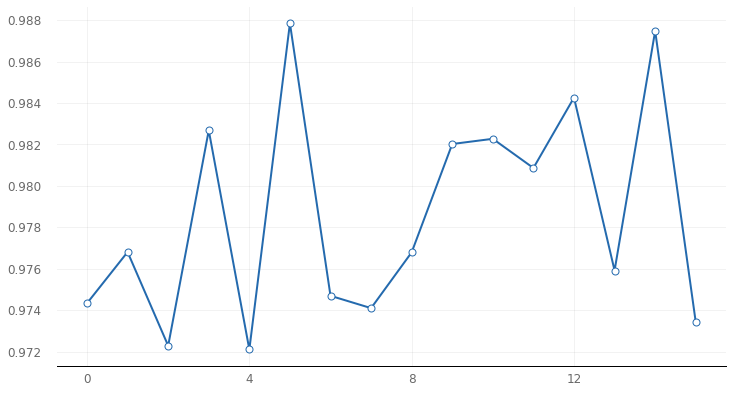

In [ ]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44737500  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d (Globa  (None, 40)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 30)                1230      
                                                             

In [ ]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 49s 12ms/step - loss: 0.0659 - accuracy: 0.9278 - val_loss: 0.0503 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 46s 11ms/step - loss: 0.0511 - accuracy: 0.9836 - val_loss: 0.0477 - val_accuracy: 0.9934


In [ ]:
model_info_1.history

{'loss': [0.06590517610311508, 0.05105257406830788],
 'accuracy': [0.9277830719947815, 0.9836123585700989],
 'val_loss': [0.050287481397390366, 0.04771357402205467],
 'val_accuracy': [0.9937958121299744, 0.9933571219444275]}

LSTM-CNN

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [ ]:
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(3)(x)
x = GlobalMaxPool1D()(x)
x = BatchNormalization()(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [ ]:
model_2 = Model(inputs=inp, outputs=preds)
model_2.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44737500  
                                                                 
 lstm_layer (LSTM)           (None, 200, 50)           70200     
                                                                 
 conv1d (Conv1D)             (None, 200, 64)           9664      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 66, 64)           0         
 )                                                               
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

In [ ]:
model_info_2=model_2.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 58s 14ms/step - loss: 0.0711 - accuracy: 0.9132 - val_loss: 0.0522 - val_accuracy: 0.9938
Epoch 2/2
3990/3990 [==============================] - 55s 14ms/step - loss: 0.0552 - accuracy: 0.9750 - val_loss: 0.0515 - val_accuracy: 0.9932


In [ ]:
model_info_2.history

{'loss': [0.07108814269304276, 0.05516887083649635],
 'accuracy': [0.9131971001625061, 0.9750268459320068],
 'val_loss': [0.05219976603984833, 0.051489125937223434],
 'val_accuracy': [0.9937645196914673, 0.9932318329811096]}

## Plotting Graphs

### LSTM

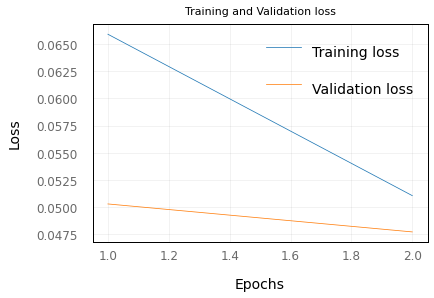

In [ ]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

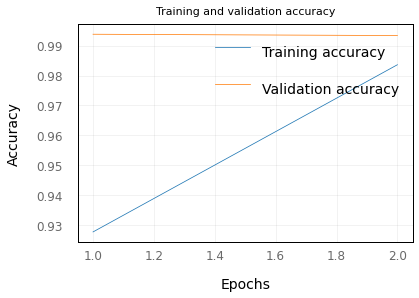

In [ ]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

### LSTM-CNN

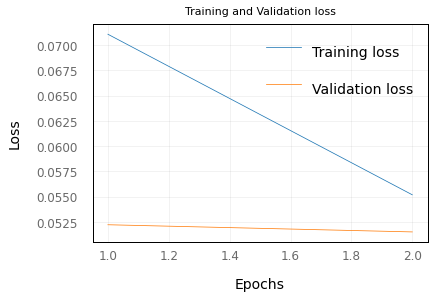

In [ ]:
loss = model_info_2.history['loss']
val_loss = model_info_2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

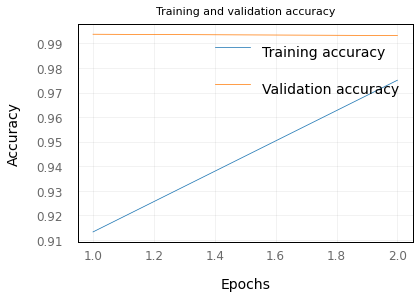

In [ ]:
accuracy = model_info_2.history['accuracy']
val_accuracy = model_info_2.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [ ]:
import json

In [ ]:
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
model_1.save("/content/drive/MyDrive/NLP/LSTM")

In [ ]:
model_2.save("/content/drive/MyDrive/NLP/LSTM-CNN")

# Loading Saved Model

In [ ]:
loaded_model_1 = keras.models.load_model("/content/drive/MyDrive/NLP/LSTM")

In [ ]:
loaded_model_2 = keras.models.load_model("/content/drive/MyDrive/NLP/LSTM-CNN")

In [ ]:
print(loaded_model_1.history)

None


# Testing the Created Model

In [ ]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = loaded_model_1.predict(new_string) #(Change to model_1 or model_2 depending on the preference of model type|| Model 1: LSTM, Model 2:LSTM-CNN)
    toxic_levels = ["TOXIC","SEVERE TOXIC","OBSCENE","THREAT","INSULT","IDENTITY HATE"]
    #print(prediction)
    print("Toxicity levels for '{}':".format(string))
    print(toxic_levels[0],':         {:.0%}'.format(prediction[0][0]))
    print(toxic_levels[1],':  {:.0%}'.format(prediction[0][1]))
    print(toxic_levels[2],':       {:.0%}'.format(prediction[0][2]))
    print(toxic_levels[3],':        {:.0%}'.format(prediction[0][3]))
    print(toxic_levels[4],':        {:.0%}'.format(prediction[0][4]))
    print(toxic_levels[5],': {:.0%}'.format(prediction[0][5]))
    print()
    m = max(prediction[0])
    t = toxic_levels[np.argmax(prediction[0])]
    if m>0.05:
      return [t,m]
    return

In [ ]:
for i in comments_test[:5]:
  toxicity_level(i)

Toxicity levels for 'people think pointless believe punitivemandates dropping nope thankyoufreedomfighters truckerconvoy holdtheline dropthemandates trudeaumustgo twj hshx':
TOXIC :         5%
SEVERE TOXIC :  0%
OBSCENE :       1%
THREAT :        0%
INSULT :        1%
IDENTITY HATE : 0%

Toxicity levels for 'working guys hardworking parents mostly moms truckerconvoy still job much gratitude amp love freeassangenow donotextraditejullian hfbh gjelf':
TOXIC :         1%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%

Toxicity levels for 'ztpetrizzo truckerconvoy still':
TOXIC :         2%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDENTITY HATE : 0%

Toxicity levels for 'rex murphy always spot analysis cdnpoli onpoli freedomconvoycanada truckersforfreedom truckerconvoy trudeaumustgo trudeaunationaldisgrace eui':
TOXIC :         0%
SEVERE TOXIC :  0%
OBSCENE :       0%
THREAT :        0%
INSULT :        0%
IDE